In [1]:
import pyross.tsi as pyrosstsi 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from scipy.optimize import newton
from scipy.special import gamma

In [2]:
def get_beta_dist(xbar, stdev, s):
    T = np.amax(s); s = s/T
    xbar = xbar/T; stdev = stdev/T

    a = xbar**2*(1-xbar)/stdev**2 - xbar
    b = (xbar*(1-xbar)/stdev**2 - 1)*(1-xbar)

    phi_alpha = s**(a - 1)*(1-s)**(b - 1)
    phi_alpha = phi_alpha/np.trapz(phi_alpha,s)/T
    
    return phi_alpha

In [3]:
##############################
##   Population Attributes  ##
##############################

M = 2                                        # Number of age groups to model
Ni = 10**6*np.ones(M)                        # Number of people in each age group
Np = sum(Ni)                                 # Total population size

#how many 'stages' to resolve in time since infection? [Predictor/Corrector only]
Nk = 10

#define a time-dependent contact matrix.
#variations on timescale less than T/Nk may not be resolved.
def contactMatrix(t):
    if t > 15 and t < 100:
        return 1*np.array([[4, 1],[1, 2]])
    else:
        return np.array([[4, 1],[1, 2]]); 


###############################
## Parameters for Inference: ##
###############################

## Parameters related to disease dynamics##

T = 40                        # Longest  infectious duration (days)
Td = 6.5                      # Doubling time in linear growth regime (days)
t_inf   = np.array([10, 5])   # Mean time since infection for transmission,    and variance for the same (days)



## Optional:  Parameters related to disease outcomes ##

subclasses = ['Recovered', 'Hospitalized', 'Mortality']  

t_rec   = np.array([15, 5])   # Mean time since infection for recovery,        and variance for the same (days)
t_h_in  = np.array([13, 5])   # Mean time since infection for hospitalization, and variance for the same (days)
t_h_out = np.array([23, 5])   # Mean time since infection for leaving hosp,    and variance for the same (days)
t_m     = np.array([25, 5])   # Mean time since infection for mortality,       and variance for the same (days)

pR = 0.99*np.ones(M);  #probability of eventually recovering for each age class
pH = 0.05*np.ones(M);  #probability of needing hospitalization for each age class
pM = 1-pR;             #probability of mortality for each age class


##############################
##   Generating TSI inputs  ##
##############################

tsi  = np.linspace(0,T,1000)                 # Time since infection (days)
beta = get_beta_dist(t_inf[0], t_inf[1],tsi) # Mean infectiousness 

tsi_sc  =  tsi
phiR     = get_beta_dist(t_rec[0], t_rec[1], tsi)   #rate of transferring to 'recovered' (arbitrary units)
phiH_in  = get_beta_dist(t_h_in[0], t_h_in[1], tsi)  #rate that people enter hospital     (arbitrary units)
phiH_out = get_beta_dist(t_h_out[0], t_h_out[1], tsi) #rate that people exit  hospital     (arbitrary units)
phiM     = get_beta_dist(t_m[0], t_m[1], tsi)     #times at which a person dies        (arbitrary units)

#combine hospital in/out to a single function for net change in hospitalized cases
phiH = -phiH_out + phiH_in

#group them all together for later processing
phi_alpha, p_alpha = np.array([phiR, phiH, phiM]), np.array([pR, pH, pM])

In [4]:
Tf = 150

parameters = {'M':M, 'Ni':Ni, 'Nc':len(subclasses), 'Nk':Nk, 'Tf':Tf, 'Tc':(T/2), 'T':T, 'Td':Td,
              'tsi':tsi,'beta':beta,'tsi_sc':tsi_sc, 'phi_alpha':phi_alpha, 'p_alpha':p_alpha, 
              'contactMatrix':contactMatrix}

model = pyrosstsi.deterministic.Simulator(parameters)
IC    = model.get_IC()
data  = model.simulate(IC)

## Plot the results using default 'Predictor Corrector':

This is preferred integrator for most cases, but it does not support adaptive timestepping.

(0, 0.01055746901166834)

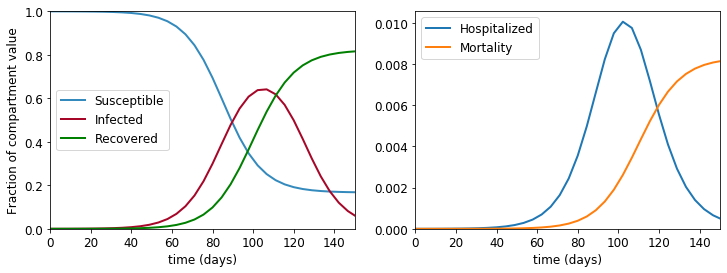

In [5]:
#unpack and rescale simulation output
t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,np.sum(I_t,0), color="#A60628", lw=2, label = 'Infected')              #all Infected
plt.plot(t,np.sum(Ic_t[0,:,:],0), color='green', lw=2, label = 'Recovered')    #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  plt.ylim(0,1)
plt.ylabel('Fraction of compartment value');   plt.legend()

plt.subplot(122) 
for i in (1 + np.arange(len(subclasses)-1)):
    plt.plot(t,np.sum(Ic_t[i,:,:],0), lw=2, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf);  plt.ylim(0) 

## Repeat same simulation using Galerkin Discretization and default integrator (odeint)

This integrator supports adaptive timestepping but it is not recommended for time-dependent contact matrices or non-smooth dynamic more generally.

(0, 0.010630390169279013)

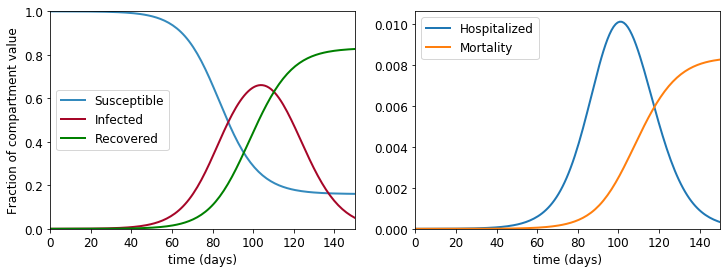

In [6]:
parameters['NL'] = 5
model = pyrosstsi.deterministic.Simulator(parameters,'Galerkin')
IC    = model.get_IC()
data  = model.simulate(IC)#,10**-3,10**-2)# <- error tolerance options

#unpack and rescale simulation output
t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,np.sum(I_t,0), color="#A60628", lw=2, label = 'Infected')              #all Infected
plt.plot(t,np.sum(Ic_t[0,:,:],0), color='green', lw=2, label = 'Recovered')    #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  plt.ylim(0,1)
plt.ylabel('Fraction of compartment value');   plt.legend();

plt.subplot(122) 
for i in (1 + np.arange(len(subclasses)-1)):
    plt.plot(t,np.sum(Ic_t[i,:,:],0), lw=2, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf);  plt.ylim(0)

## Repeat the same using Galerkin discretization and Crank Nicolson integrator

This integrator supports adaptive time-stepping and is preferable to 'odeint' whenever the contact matrix is time-dependent.  Still not recommended for non-smooth dynamics (e.g. lockdown).  When the contact matrix is time-dependent and piecewise smooth, consider using the Hybrid method (see example notebook on the subject).

(0, 0.010620828890744132)

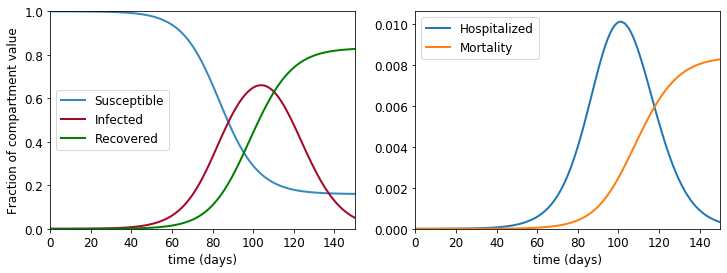

In [7]:
parameters['NL'] = 5
model = pyrosstsi.deterministic.Simulator(parameters,'Galerkin','Crank Nicolson')
IC    = model.get_IC()
data  = model.simulate(IC,10**-3*4,10**-2*4)# <- error tolerance options

#unpack and rescale simulation output
t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,np.sum(I_t,0), color="#A60628", lw=2, label = 'Infected')              #all Infected
plt.plot(t,np.sum(Ic_t[0,:,:],0), color='green', lw=2, label = 'Recovered')    #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  plt.ylim(0,1)
plt.ylabel('Fraction of compartment value');   plt.legend();

plt.subplot(122) 
for i in (1 + np.arange(len(subclasses)-1)):
    plt.plot(t,np.sum(Ic_t[i,:,:],0), lw=2, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf); plt.ylim(0)